# Estimating the Proc2D mean in the Cov.-Smoothing Basis

Import libraries.

In [22]:
# Required
library(mgcv)
library(sparseFLMM)
library(dplyr)

# To deal with SRV framework
#detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasticproc2d")
library(elasdics2d)

# Plotting
library(ggplot2)
library(gridExtra)
library(viridis)
library(rgl)
library(fields)

# Datasets
source("../scripts/load_datasets.R")

Loading required package: nlme

This is mgcv 1.8-35. For overview type 'help("mgcv-package")'.

Loading required package: refund


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




tibble (3.1.1  -> 3.1.2 ) [CRAN]
lme4   (1.1-26 -> 1.1-27) [CRAN]


Installing 2 packages: tibble, lme4




  There are binary versions available but the source versions are later:
       binary source needs_compilation
tibble  3.1.1  3.1.2              TRUE
lme4   1.1-26 1.1-27              TRUE

  Binaries will be installed
package 'tibble' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'tibble'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\R\R-4.0.5\library\00LOCK\tibble\libs\x64\tibble.dll to C:\R\R-4.0.5\library\tibble\libs\x64\tibble.dll: Permission denied"
Warning message:
"restored 'tibble'"


package 'lme4' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'lme4'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\R\R-4.0.5\library\00LOCK\lme4\libs\x64\lme4.dll to C:\R\R-4.0.5\library\lme4\libs\x64\lme4.dll: Permission denied"
Warning message:
"restored 'lme4'"



The downloaded binary packages are in
	C:\Users\manue\AppData\Local\Temp\Rtmp6RRQr9\downloaded_packages
v  checking for file 'D:\Dropbox\Statistik\elasticproc2d/DESCRIPTION' (336ms)
-  preparing 'elasticproc2d': (1.2s)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts (337ms)
-  checking for empty or unneeded directories
-  building 'elasticproc2d_0.1.0.tar.gz'
   
Running "C:/R/R-4.0.5/bin/x64/Rcmd.exe" INSTALL \
  "C:\Users\manue\AppData\Local\Temp\Rtmp6RRQr9/elasticproc2d_0.1.0.tar.gz" \
  --install-tests 
* installing to library 'C:/R/R-4.0.5/library'
* installing *source* package 'elasticproc2d' ...
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
  converting help for package 'elasticproc2d'
    finding HTML links ... done
    compute_elastic_proc2d_mean             html  
    compute_proc2d_alignment                html  
    elasticproc2d 


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



## Prepare Dataset
Load dataset and transform curves to SRV framework.

In [23]:
set.seed(18)

#data_curves <- curves.spiral(n_curves=10, rotate=TRUE, scale=TRUE, center=TRUE)
data_curves <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)

# Create arc length parametrization.
data_curves <- lapply(data_curves, function(data_curve) {
    data.frame(t = get_arc_length_param(data_curve), data_curve)
})

normalize_curve <- function(curve) {
    dx = diff(curve$X1)
    dy = diff(curve$X2)
    l = sum(sqrt(dx^2 + dy^2))
    curve$X1 = curve$X1 / l
    curve$X2 = curve$X2 / l
    curve
}

data_curves <- lapply(data_curves, normalize_curve)
data_curves <- lapply(data_curves, center_curve)

# Get SRV data curves.
srv_data_curves <- lapply(data_curves, get_srv_from_points)

Get model data!

In [24]:
# Reparametrize SRV data curves and put curves into long (stacked) format.
knots = seq(0, 1, length=11) 
type = "smooth"
h = 0.01  # arg.grid step size
t_optims <- lapply(srv_data_curves, function(srv_data_curve) { c(srv_data_curve$t, 1) })
model_data_complex <- elasticproc2d:::get_model_data_complex(t_optims, srv_data_curves, knots, type=type)

Registered S3 methods overwritten by 'elasdics':
  method              from      
  plot.aligned_curves elasdics2d
  plot.elastic_mean   elasdics2d



## Estimate Covariance Surface
Build covariance response on (s,t) grid.

In [25]:
cov_dat <- lapply(split(model_data_complex, model_data_complex$id), function(x) {
    combs <- combn(1:nrow(x),2)
    data.frame(
        qq = x$q_m_long[combs[1,]] * Conj(x$q_m_long[combs[2,]]),
        s = x$m_long[combs[1,]],
        t = x$m_long[combs[2,]]
    )
})
cov_dat <- do.call(rbind,cov_dat)

Fit covariance surface using ```mgcv```.

In [26]:
# Parameters for covariance smoothing
cov.m = ifelse(type == "smooth", 0, -1)  # spline degree - 1
#cov.m = ifelse(type == "cubic", 2, cov.m)
cov.d = 2 # penalty

# Build knots
knotl = 1 / ( length(knots) - 1 )  # mean length of a knot
cov.knots = c(rep(-knotl,cov.m+1), knots, rep(1+knotl,cov.m+1))  # knots at 0,1
cov.k = length(cov.knots) - cov.m - 2 # basis dimension.

# Smooth covariance surface
cov_fit_re <- bam(Re(qq) ~ s(s, t , bs="symm", k = cov.k, m = c(cov.m, cov.d),
                            fx = FALSE, xt = list(skew = FALSE)),
                  data = cov_dat, method = "REML", knots=list(s = cov.knots, t = cov.knots))
cov_fit_im <- bam(Im(qq) ~ -1 + s(s, t, bs="symm", k = cov.k, m = c(cov.m, cov.d),
                                  fx = FALSE, xt = list(skew = TRUE)),
                  data = cov_dat, method = "REML", knots=list(s = cov.knots, t = cov.knots))

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"


Plot covariance surface on a grid.

In [27]:
# Define covariance surface grid (s,t).
arg.grid = seq(0, 1, by=h)
cov.grid = expand.grid(t = arg.grid, s = arg.grid)
# Evaluate fit on grid.
cov.re = predict(cov_fit_re, newdata = cov.grid)
cov.im = predict(cov_fit_im, newdata = cov.grid)

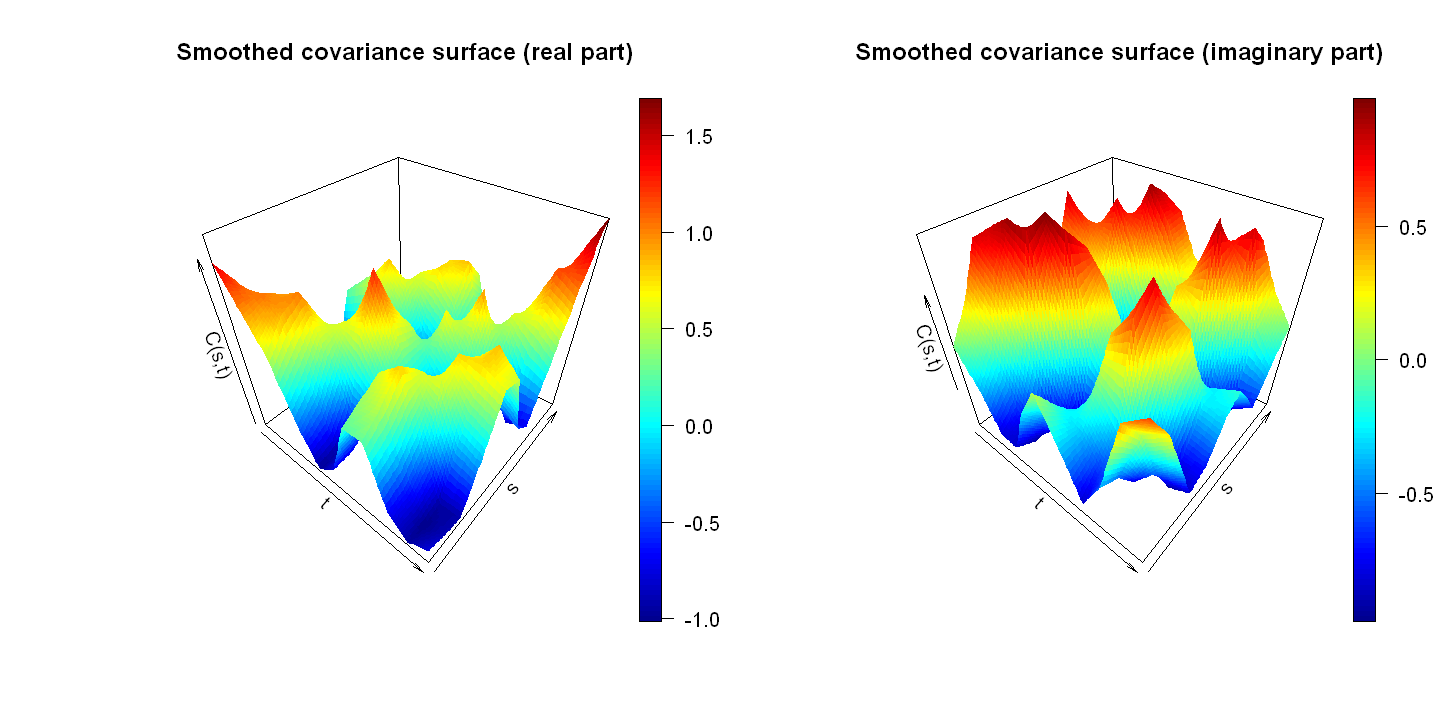

In [28]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (imaginary part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

## Estimate Procrustes Mean Shape in fixed Basis
Check basis functions from covariance smoothing.

In [29]:
arg.grid = seq(0, 1, by=h)
smooth1D <- smooth.construct(s(t, bs="ps", k = cov.k, m = c(cov.m, cov.d),
                              fx = FALSE),
                            data = list(t=arg.grid), knots=list(t=cov.knots))

#### Extract coefficient matrix from mgcv smooth.

In [30]:
# get coefficient matrix for pca
get_complex_coef_matrix <- function(cov_fit){
  beta.mat.re <- get_coef_matrix_from_model(cov_fit$re)
  beta.mat.im <- get_coef_matrix_from_model(cov_fit$im)
  matrix(complex(real = as.vector(beta.mat.re), imaginary = as.vector(beta.mat.im)), ncol = ncol(beta.mat.re))
}

get_coef_matrix_from_model <- function(model){
  coefs <- get_unconstrained_basis_coefs(model)
  s_ <- model$smooth[[1]]
  beta <- s_$Z %*% coefs
  F <- s_$bs.dim
  matrix(beta, nrow=F, ncol=F)
}

get_unconstrained_basis_coefs <- function(model){
  s_ <- model$smooth[[1]]

  # Create toy data that ensures identifiability of trafo mat.
  knots <- s_$knots
  knots_mid <- knots[-length(knots)] + 0.5 * diff(knots)
  knots_mid <- knots_mid[-length(knots_mid)]
  knots_all <- unique(sort(c(knots,knots_mid)))
  toy_dat <- expand.grid(s = knots_all, t = knots_all)
  toy_dat$y <- rnorm(nrow(toy_dat))

  # Create toy design matrix and calculate trafo matrix.
  X <- Predict.matrix(s_, toy_dat)
  print(dim(X))
  X_ <- PredictMat(s_, toy_dat)
  print(dim(X_)) 
  print(all.equal(X, X_))
  X_ <- if(s_$xt$skew == TRUE) {X_} else {cbind(1, X_)}
  D <- solve(crossprod(X), crossprod(X, X_))

  # Set Intercept to 0 if skew-symmetric basis.
  #coefs_ <- if(s_$xt$skew == FALSE) {coef(model)} else {c(0, coef(model)[-1])}
  coefs_ <- coef(model)

  # Apply trafo to estimated constrained coefficients.
  D %*% coefs_
}

In [31]:
get_coef_matrix_old <- function(model){
    F <- model$smooth[[1]]$bs.dim
    beta <- model$smooth[[1]]$Z %*% model$coefficients
    matrix(beta, nrow=F, ncol=F)
}

In [32]:
build_gram_matrix <- function(smooth){
    order = smooth$m[1] + 2  # degree + 1
    knots = smooth$knots  # inner+outer knots
    if( order == 1 ){
        1/(length(knots) - 1) * diag(length(knots) - 1)  # Note: ONLY CORRECT FOR EQUIDISTANT KNOTS!!!
    } else {
        osb_smooth = orthogonalsplinebasis::SplineBasis(knots,order=order)
        orthogonalsplinebasis::GramMatrix(osb_smooth)
    }
}

G <- build_gram_matrix(smooth1D)

In [33]:
cov_fit <- list("re" = cov_fit_re, "im" = cov_fit_im)
beta.mat <- get_complex_coef_matrix(cov_fit)

beta.mat.inv = solve(beta.mat)

[1] 576  66
[1] 576  65
[1] "Attributes: < Component \"dim\": Mean relative difference: 0.01515152 >"
[2] "Numeric: lengths (38016, 37440) differ"                                 
[1] 576  55
[1] 576  55
[1] TRUE


## PCA on coef matrix

In [34]:
printl <- function(curve){
    curve <- data.frame("t" = get_arc_length_param(curve), curve)
    dx = diff(curve$X1)
    dy = diff(curve$X2)
    l = sum(sqrt(dx^2 + dy^2))
    print(l)
}

#### A. PCA on big coef mat (identifying $\mathbb{C}^k$ with $\mathbb{R}^{2k}$)

In [35]:
# build big matrix
big.beta.mat <- cbind(c(1,0), c(0,1)) %x% (chol(G) %*% Re(beta.mat) %*% t(chol(G))) + cbind(c(0,-1), c(1,0)) %x% (chol(G) %*% Im(beta.mat) %*% t(chol(G)))
pca.stacked <- eigen(big.beta.mat)
coefs.mean <- cbind(c(1,0), c(0,1)) %x% solve(chol(G)) %*% pca.stacked$vectors[,1]
print(t(coefs.mean) %*% ( cbind(c(1,0),c(0,1)) %x% G) %*% coefs.mean)
coefs.mean <- complex(real = coefs.mean[seq(1,dim(beta.mat)[1])], imaginary = coefs.mean[seq(1,dim(beta.mat)[1]) + dim(beta.mat)[1]])

     [,1]
[1,]    1


In [36]:
# Check if is unitlength. Whyyyy?
print(t(Conj(coefs.mean)) %*% G %*% coefs.mean)
print(c(pca.stacked$values[1]))
print(max(Re(pca.stacked$values)))

     [,1]
[1,] 1+0i
[1] 0.7415648
[1] 0.7415648


In [37]:
qt <- elasdics2d:::make_design(arg.grid, knots, type = type) %*% coefs.mean
qt.xy <- data.frame(t=arg.grid, X1=Re(qt), X2=Im(qt))
bt.xy <- get_points_from_srv(qt.xy)
bt.xy <- center_curve(bt.xy)
printl(qt.xy)
printl(bt.xy)

[1] 8.382003
[1] 1.001826


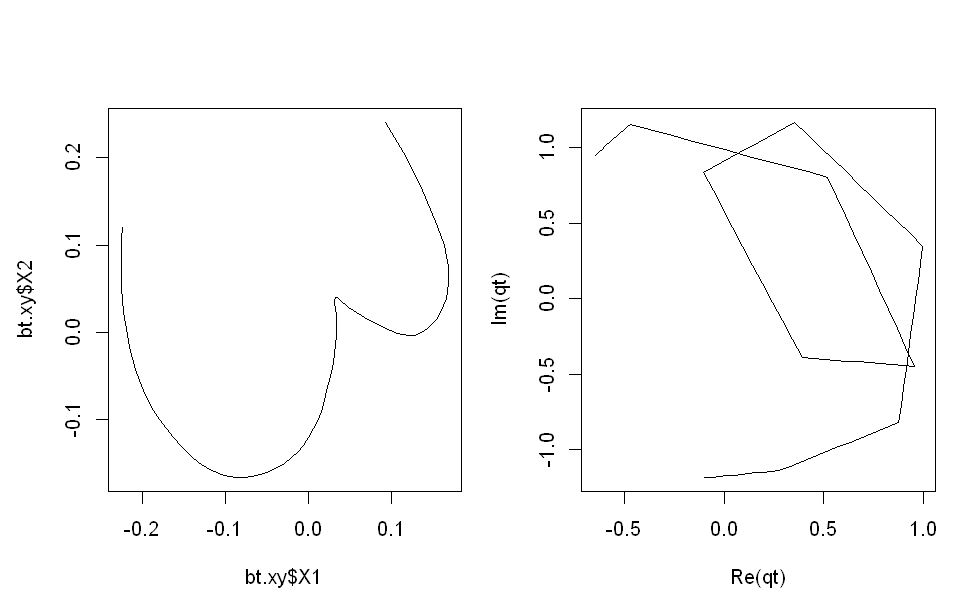

In [38]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(bt.xy$X1, bt.xy$X2, t="l")
matplot(Re(qt), Im(qt), t="l")

#### B. PCA on complex coef matrix.

In [39]:
# Calculate largest eigenvector
pca <- eigen(chol(G) %*% beta.mat %*% t(chol(G)))
coefs.mean <- solve(chol(G)) %*% Conj(pca$vectors[,1])

In [40]:
# Check if is unitlength.
as.numeric(Re(t(Conj(coefs.mean)) %*% G %*% coefs.mean))

[1] 1

In [41]:
# Check eigenvalues
pca$values[1]
max(Re(pca$values))

[1] 0.7415648

[1] 0.7415648

In [42]:
qt <- elasdics2d:::make_design(arg.grid, knots, type = type) %*% coefs.mean
qt.xy <- data.frame(t=arg.grid, X1=Re(qt), X2=Im(qt))
bt.xy <- get_points_from_srv(qt.xy)
bt.xy <- center_curve(bt.xy)
printl(qt.xy)
printl(bt.xy)

[1] 8.382003
[1] 1.001826


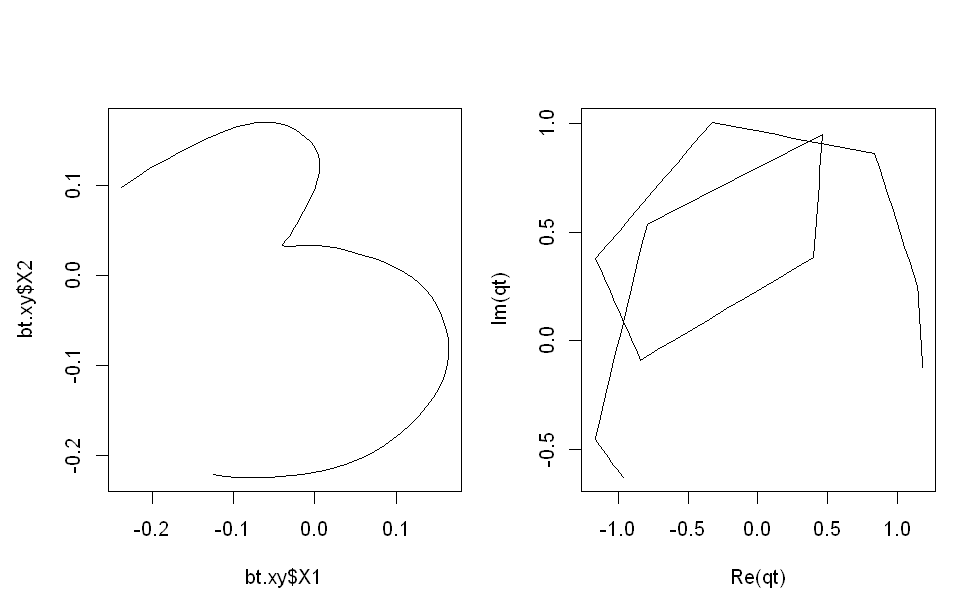

In [43]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(bt.xy$X1, bt.xy$X2, t="l")
matplot(Re(qt), Im(qt), t="l")

### Plot Procrustes Fits + Mean from fixed basis (Note: No warping!)

In [44]:
pfits <- lapply(1:length(srv_data_curves), function(j) {
    
    q <- model_data_complex[model_data_complex$id == j,]
    
    t1 <- q$m_long[1]
    tn <- q$m_long[length(q$m_long)]
    arg.grid.x <- seq(2*t1, 2*tn-1, by=h)

    # Size of overlap.
    Dt <- arg.grid.x[length(arg.grid.x)] - arg.grid.x[1]
    
    # Linear interpolation of srv data curve on overlap.
    q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
    q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
    q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
    
    # Evaluate mean function on overlap.
    mean_eval <- elasdics2d:::make_design(arg.grid.x, knots=knots, closed = FALSE, type = type) %*% coefs.mean
    mean1 <- elasdics2d:::make_design(t1, knots=knots, closed=FALSE, type=type) %*% coefs.mean
    meann <- elasdics2d:::make_design(tn, knots=knots, closed=FALSE, type=type) %*% coefs.mean
    
    # Calculate pfit scaling+rotation
    qm <- Conj(q_approx) * mean_eval
    qm1 <- Conj(q$q_m_long[1]) * mean1
    qmn <- Conj(q$q_m_long[length(q$q_m_long)]) * meann
    
    qq <- Conj(q_approx) * q_approx
    qq1 <- Conj(q$q_m_long[1]) * q$q_m_long[1]
    qqn <- Conj(q$q_m_long[length(q$q_m_long)]) * q$q_m_long[length(q$q_m_long)]
    
    # Numerical Integration using trapezoid rule.
    qm <- h * ( sum(qm) - 0.5*qm[1] - 0.5*qm[length(qm)] ) + 2*t1*qm1 + 2*(1-tn)*qmn 
    qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] ) + 2*t1*qq1 + 2*(1-tn)*qqn
    qq <- Re(qq)
    if(j == 4){
        print("Checks :")
        print(paste0("Dt ", Dt, "    qq ", qq, "    qm ", qm))
        print(paste0("G_optim ", Arg(qm)/pi, " pi     b_optim ", (Mod(qm) / qq)^2))
    }
    
    # Calculate G and b (Note: using "<<-" is not good practice...)
    #G_optims[j] <<- Arg(qm)
    # Note: squared to adjust for SRV framework. b is on data_curve level!!!
    #b_optims[j] <<- (Mod(qm) / Re(qq))^2
    
    # Grab unwarped srv curves.
    srv_complex = complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    # Apply scaling+rotation
    pfit <- c(qm/qq) * srv_complex
    #pfit <- exp(1.i*Arg(c(qm))) * srv_complex
    pfit <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    
    #center_curve(get_points_from_srv(pfit))
})

[1] "Checks :"
[1] "Dt 0.85    qq 0.856169056507465    qm 0.877882696108798+0.048461354411835i"
[1] "G_optim 0.0175536980248245 pi     b_optim 1.0545698345079"


In [45]:
pfits <- lapply(1:length(srv_data_curves), function(j) {
    
    q <- model_data_complex[model_data_complex$id == j,]
    
    # Calculate overlap of arg.grid and t_optims.
    #idx <- findInterval(arg.grid, q$m_long)
    #idx.bool <- which(idx > 0 & idx < length(q$m_long))
    #arg.grid.x <- arg.grid[idx.bool]
    
    # Size of overlap.
    Dt <- arg.grid[length(arg.grid)] - arg.grid[1]
    
    # Linear interpolation of srv data curve on overlap.
    q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid, rule=2)$y
    q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid, rule=2)$y
    q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)
    
    # Evaluate mean function on overlap.
    mean_eval <- elasdics2d:::make_design(arg.grid, knots=knots, closed = FALSE, type = type) %*% coefs.mean
    #mean_eval <- smooth1D$X %*% coefs.mean
    
    # Calculate pfit scaling+rotation
    qq <- Conj(q_approx) * q_approx
    qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] )
    
    q_norm_approx <- sqrt(qq) * q_approx
    qm <- Conj(q_norm_approx) * mean_eval
    qm <- h * ( sum(qm) - 0.5*qm[1] - 0.5*qm[length(qm)] )
    
    if(j == 4){
        mm <- Conj(mean_eval) * mean_eval
        mm <- h * ( sum(mm) - 0.5*mm[1] - 0.5*mm[length(mm)])
        mTm <- t(Conj(coefs.mean)) %*% G %*% coefs.mean
        print("Checks :")
        print(paste0("Dt ", Dt, "    qq ", qq, "    qm ", qm, "    mm ", mm, "   mTm ", mTm))
        print(paste0("G_optim ", Arg(qm)/pi, " pi     b_optim ", (Mod(qm) / qq)^2))
    }
    
    # Calculate G and b (Note: using "<<-" is not good practice...)
    #G_optims[j] <<- Arg(qm)
    # Note: squared to adjust for SRV framework. b is on data_curve level!!!
    #b_optims[j] <<- (Mod(qm) / Re(qq))^2
    
    # Grab unwarped srv curves.
    srv_complex = complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    # Apply scaling+rotation
    pfit <- c(qm/sqrt(qq)) * srv_complex
    #pfit <- exp(1.i*Arg(c(qm))) * srv_complex
    pfit <- data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    
    #center_curve(get_points_from_srv(pfit))
})

[1] "Checks :"
[1] "Dt 1    qq 0.856450773317787+0i    qm 0.815219528712646+0.039107129359864i    mm 1.00140140700624+0i   mTm 1-0i"
[1] "G_optim 0.0152580376793274 pi     b_optim 0.908118675935344+0i"


In [46]:
pfits <- lapply(1:length(srv_data_curves), function(j) {

      q <- model_data_complex[model_data_complex$id == j,]

      # Calculate overlap of arg.grid and t_optims.
      idx <- findInterval(arg.grid, q$m_long)
      idx.bool <- which(idx > 0 & idx < length(q$m_long))
      arg.grid.x <- arg.grid[idx.bool]
      #Dt <- arg.grid.x[length(arg.grid.x)] - arg.grid.x[1]

      # Linear interpolation of srv data curve on overlap.
      q_approx_x <- approx(x=q$m_long, y=Re(q$q_m_long), xout=arg.grid.x)$y
      q_approx_y <- approx(x=q$m_long, y=Im(q$q_m_long), xout=arg.grid.x)$y
      q_approx <- complex(real=q_approx_x, imaginary=q_approx_y)

      # Evaluate mean function on overlap.
      mean_eval <- elasdics2d:::make_design(arg.grid.x, knots = knots, closed = FALSE, type = type) %*% coefs.mean

      # Calculate pfit scaling+rotation
      qm <- Conj(q_approx) * mean_eval
      qq <- Conj(q_approx) * q_approx

      # Numerical Integration using trapezoid rule.
      qm <- h * ( sum(qm) - 0.5*qm[1] - 0.5*qm[length(qm)] )
      qq <- h * ( sum(qq) - 0.5*qq[1] - 0.5*qq[length(qq)] )  # should be 1.

      # Calculate procrustes fit of original srv_data_curve
      srv_complex = complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])

      pfit <- c(qm/qq) * srv_complex
      data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
    })

Smoothed pfits

In [47]:
pfits_coef <- lapply(1:length(srv_data_curves), function(j) {

    q <- model_data_complex[model_data_complex$id == j,]
    q_B <- elasdics2d:::make_design(q$m_long, knots, type = type, closed = FALSE)
    
    # Estimate coeficients as restricted LSE
    q_coefs <- solve( t(q_B) %*% q_B + Conj(beta.mat.inv)) %*% t(q_B) %*% q$q_m_long

    # Normalize coefficients
    norm <- sqrt(t(Conj(q_coefs)) %*% G %*% q_coefs)
    q_coefs <- q_coefs / c(norm)

    # Calculate pfit scaling+rotation
    qm <- t(Conj(q_coefs)) %*% G %*% coefs.mean
    qq <- t(Conj(q_coefs)) %*% G %*% q_coefs
    
    # Grab unwarped srv curves.
    srv_complex <- complex(real = srv_data_curves[[j]][,2], imaginary = srv_data_curves[[j]][,3])
    
    # Apply scaling+rotation
    pfit <- c(qm/qq) * srv_complex
    data.frame(t = srv_data_curves[[j]][,1], X1 = Re(pfit), X2 = Im(pfit))
})

### Plot Results

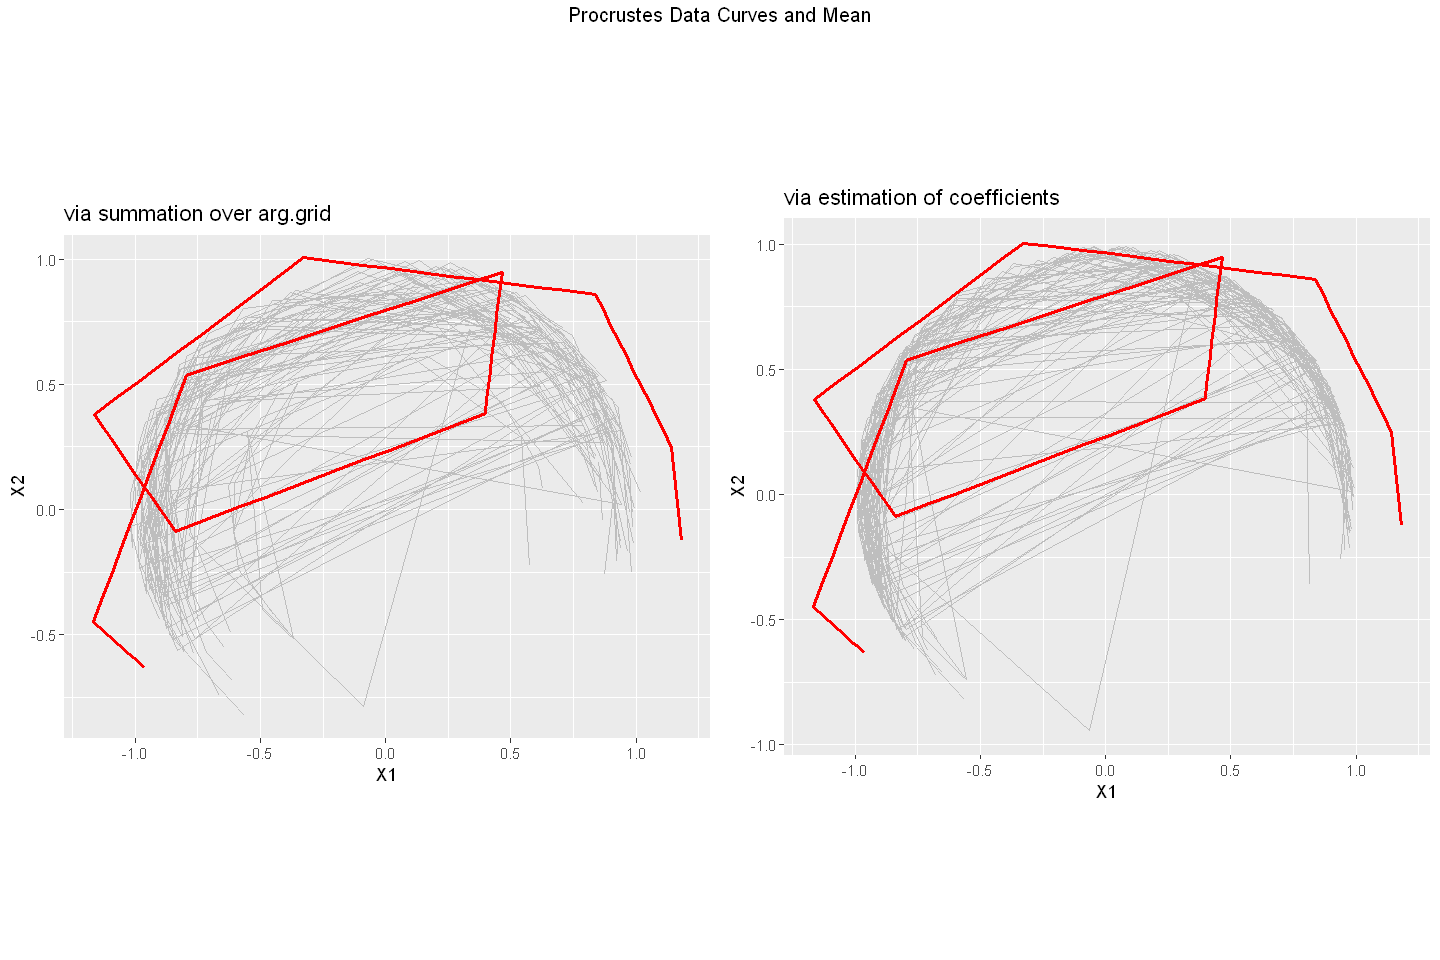

In [48]:
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=qt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via summation over arg.grid")
   

p2 <- ggplot(bind_rows(pfits_coef, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=qt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via estimation of coefficients")
    
options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

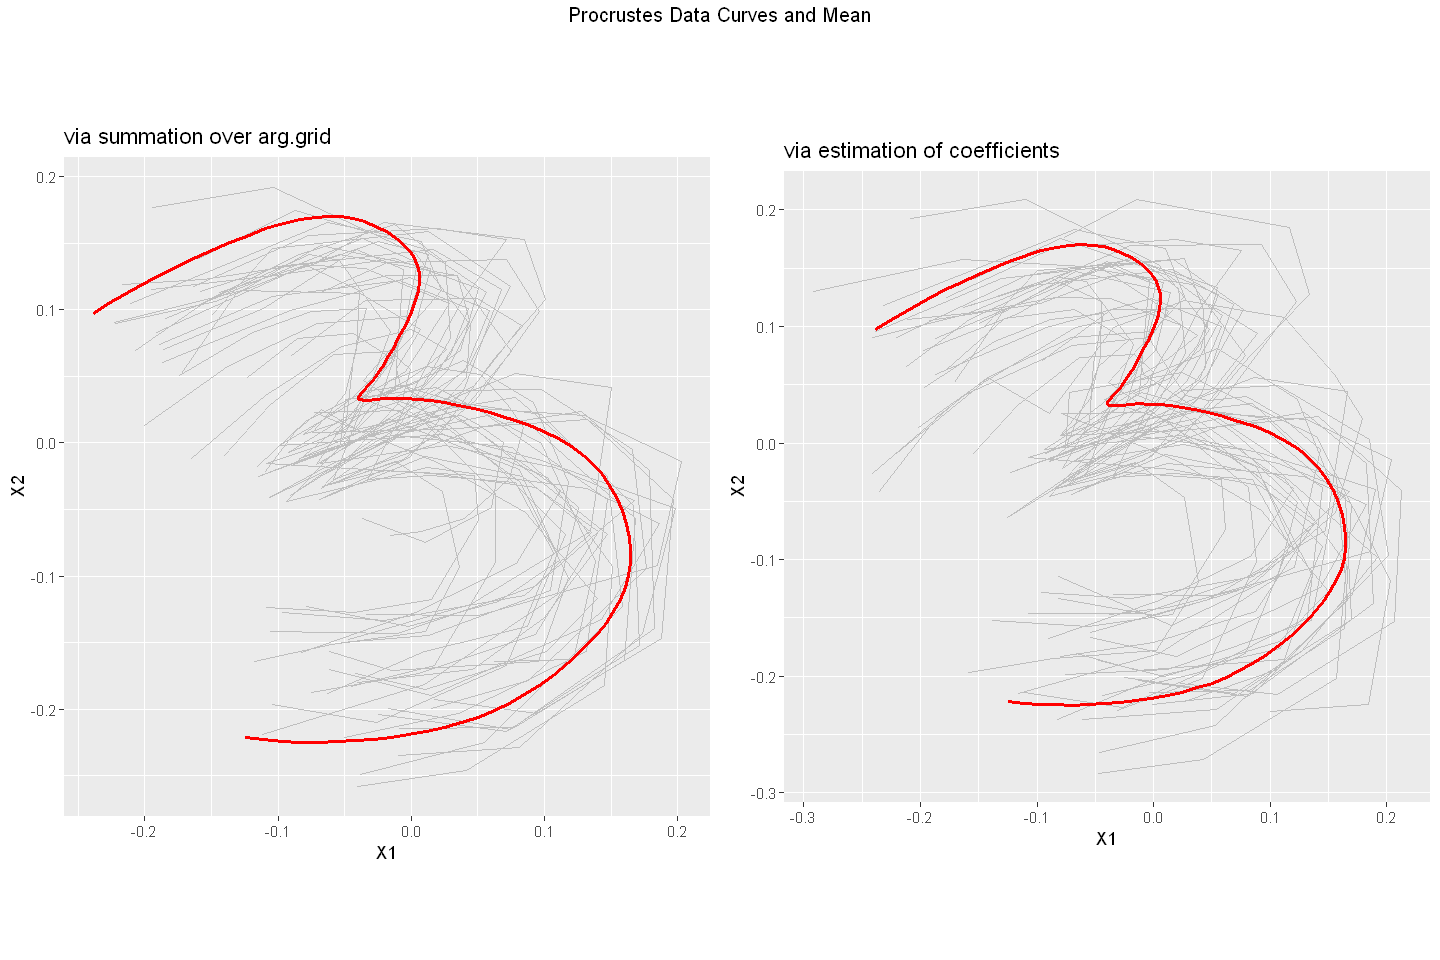

In [49]:
pfits_dta <- lapply(pfits, function(pfit) {
    center_curve(get_points_from_srv(pfit))
})
    
pfits_dta_coef <- lapply(pfits_coef, function(pfit) {
    center_curve(get_points_from_srv(pfit))
})
    
p1 <- ggplot(bind_rows(pfits_dta, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via summation over arg.grid")
   

p2 <- ggplot(bind_rows(pfits_dta_coef, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    #coord_fixed(ylim=c(-0.012,0.012),xlim=c(-0.012,0.012)) +
    coord_fixed() +
    ggtitle("via estimation of coefficients")
    
options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

### Plot Data Curves and Pfits

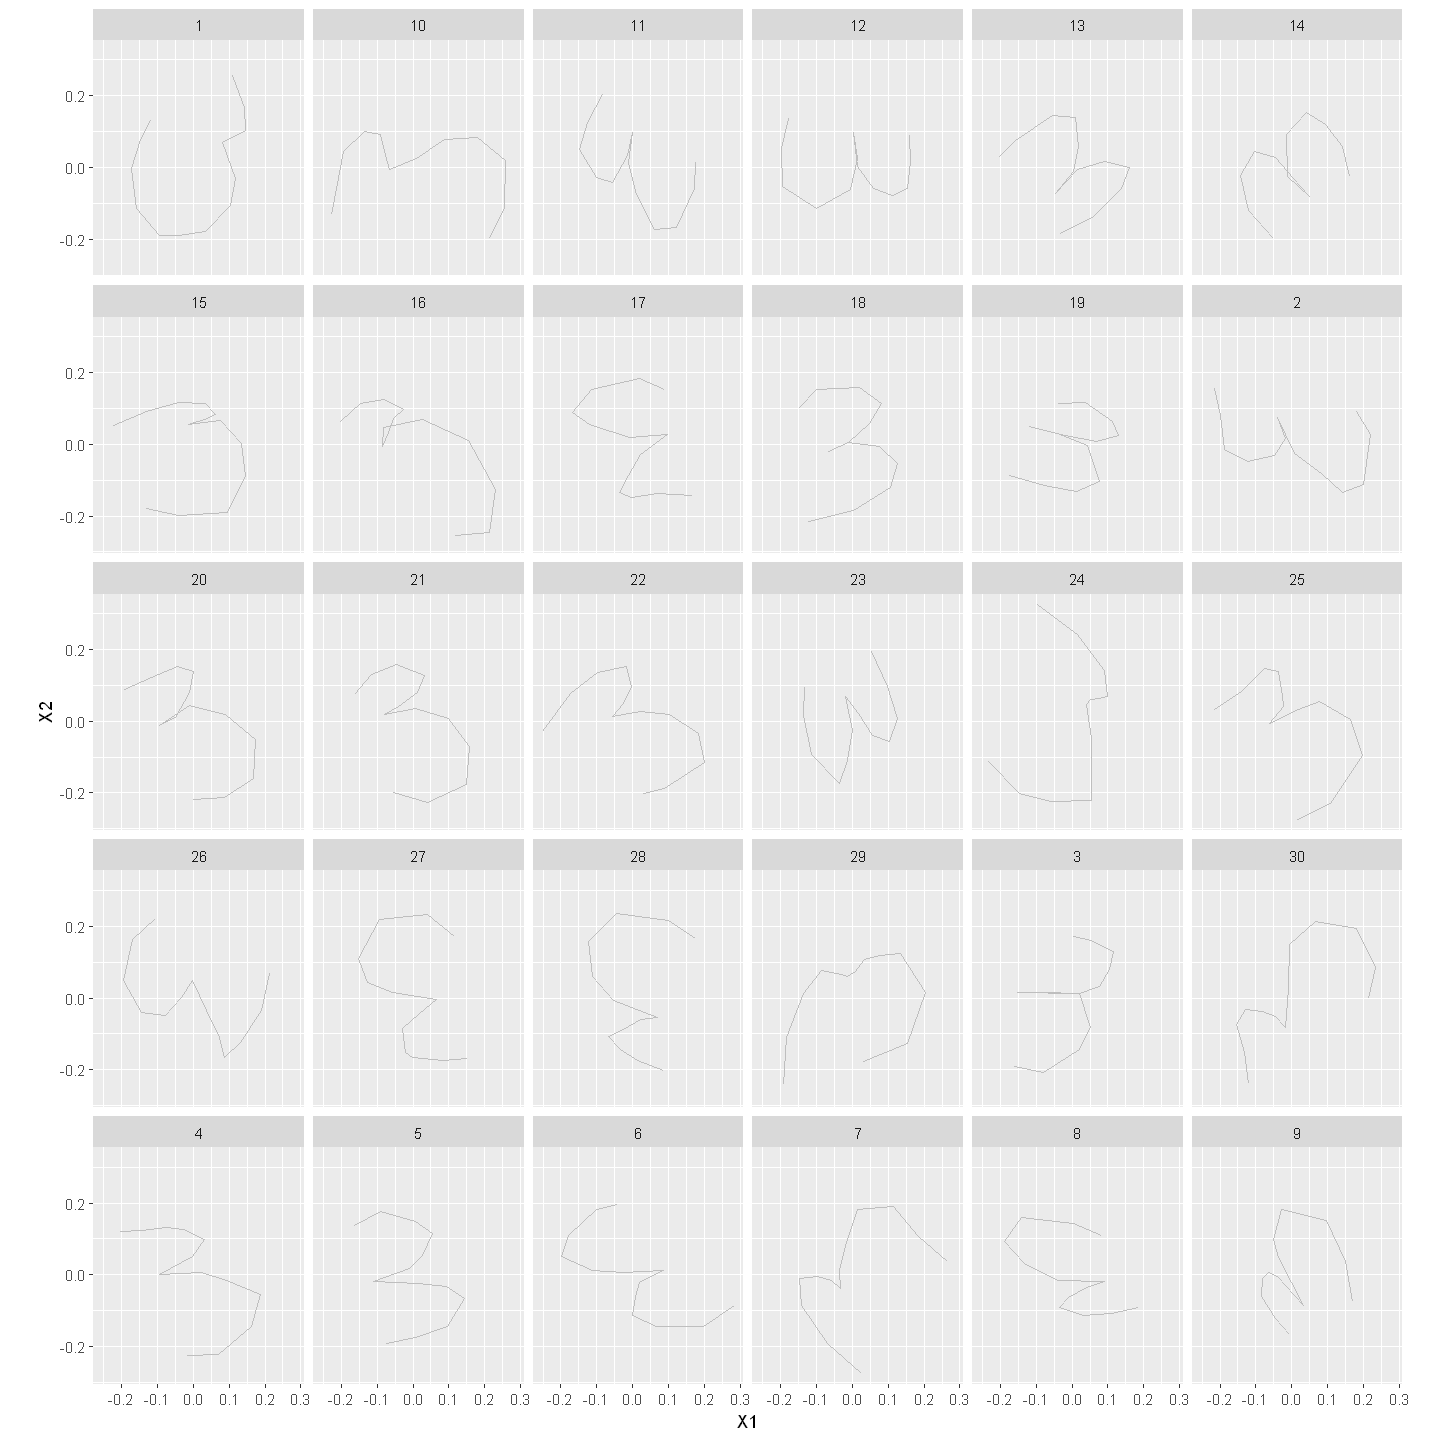

In [50]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(bind_rows(data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    coord_fixed() + 
    facet_wrap(~id)

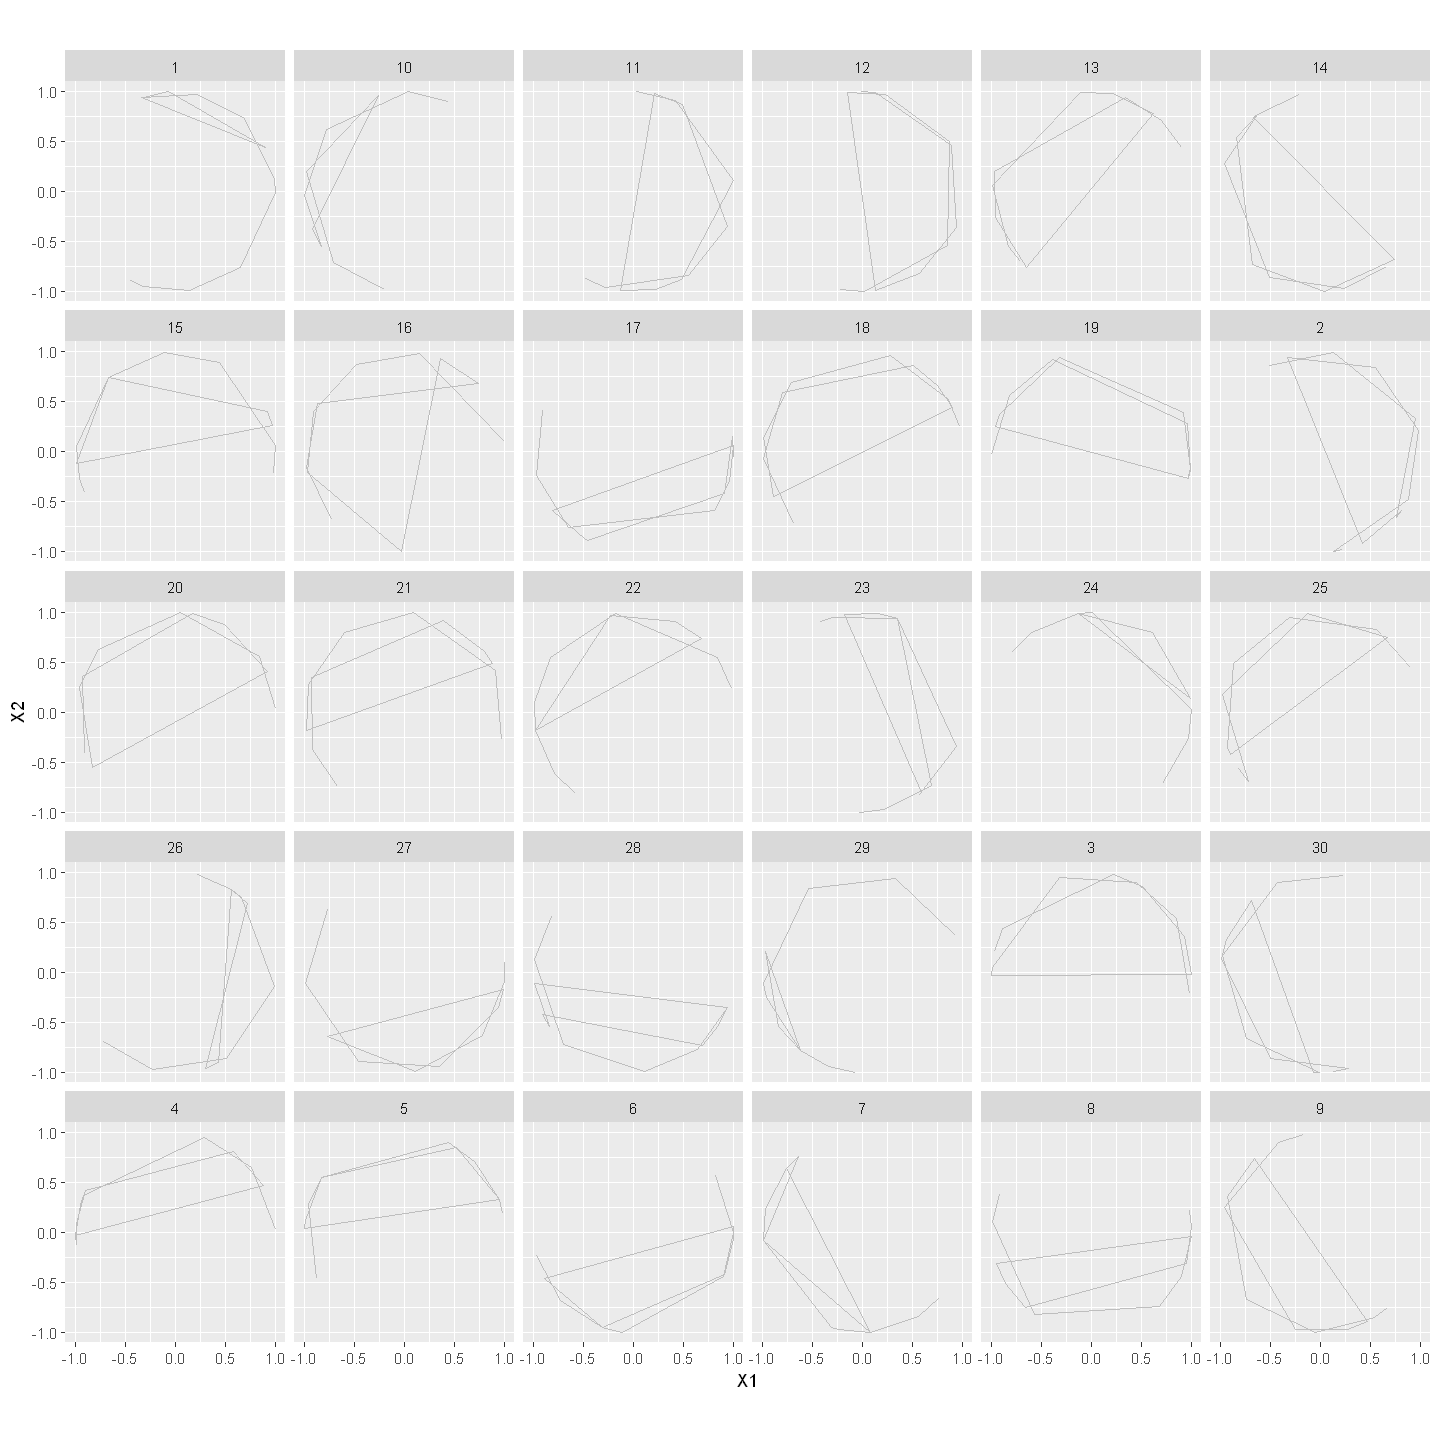

In [51]:
ggplot(bind_rows(srv_data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    coord_fixed() + 
    facet_wrap(~id)

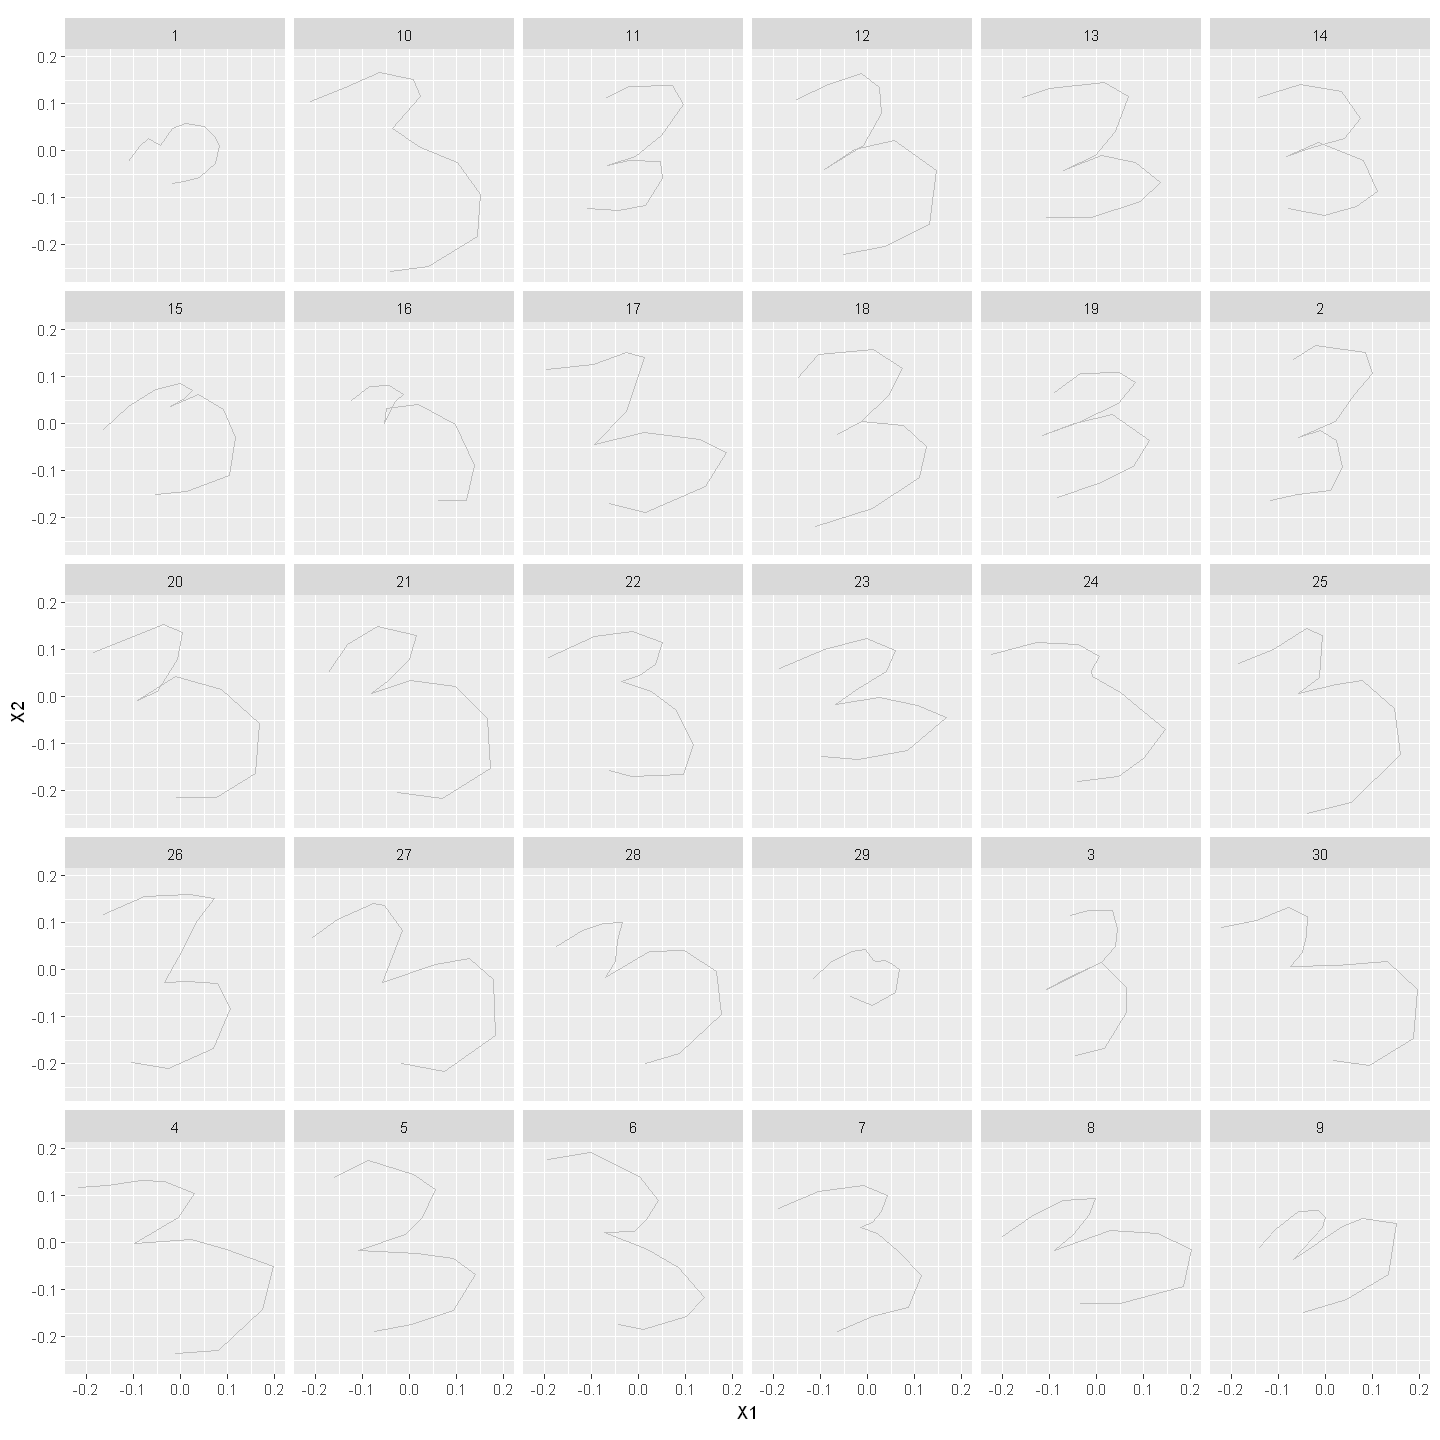

In [52]:
ggplot(bind_rows(pfits_dta, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    coord_fixed() + 
    facet_wrap(~id)

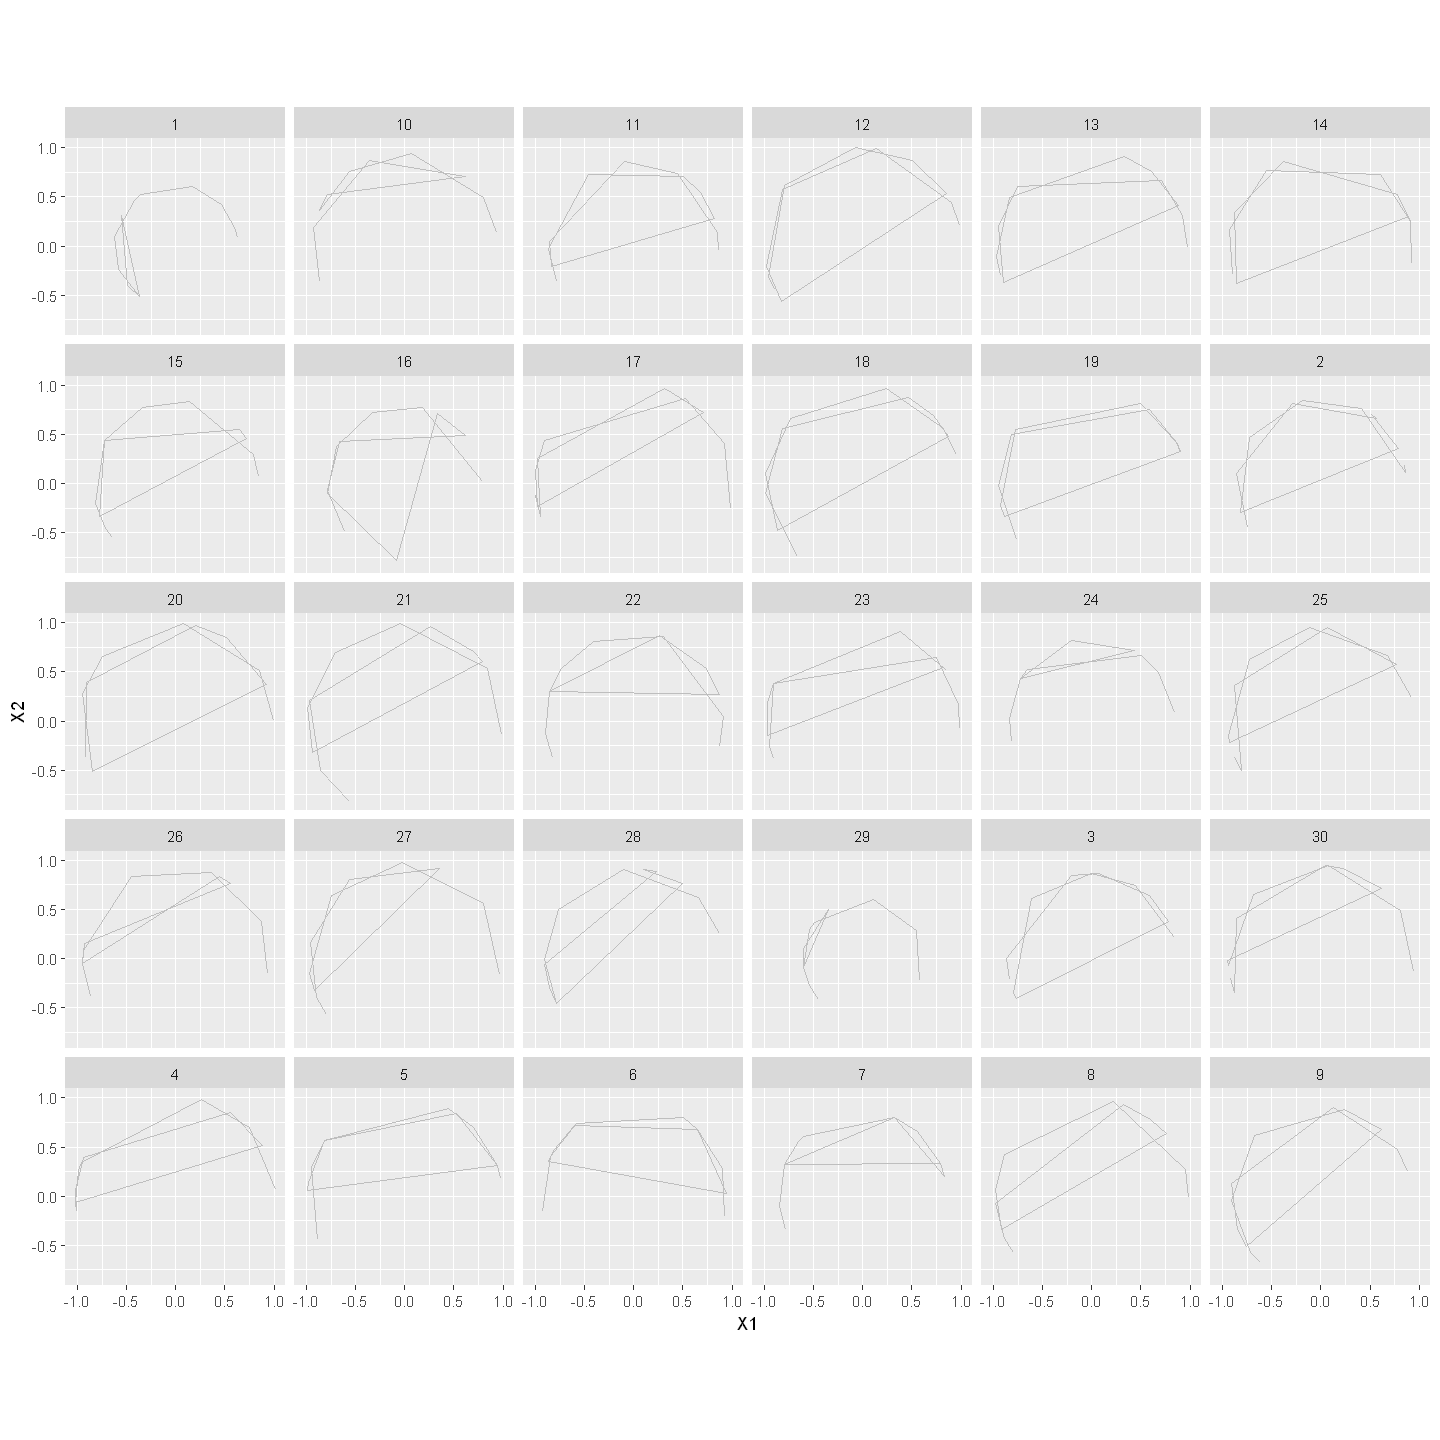

In [53]:
ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    coord_fixed() + 
    facet_wrap(~id)